In [6]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [7]:
data = pd.read_excel("../Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


In [11]:
df_location = pd.read_pickle("df_location.pkl")
df_location.reset_index(drop=True, inplace=True)
df_location = df_location.iloc[:, [0, 2, 1]]
df_location

,Time,Location,Energy
0,2019-01-01 00:00:00,0,2.964000
1,2019-01-01 00:15:00,0,2.584000
2,2019-01-01 00:30:00,0,3.071000
3,2019-01-01 00:45:00,0,2.694000
4,2019-01-01 01:00:00,0,2.569000
...,...,...,...
1791931,2020-01-01 22:45:00,50,0.753222
1791932,2020-01-01 23:00:00,50,0.716855
1791933,2020-01-01 23:15:00,50,0.735802
1791934,2020-01-01 23:30:00,50,0.485237


In [24]:
num_samples_per_house = 35136
num_houses = 51

In [25]:
def no_ml_predict(X, y):
    mse = mean_squared_error(X, y)
    wape = np.round(mean_absolute_error(X,y) / y.mean(), 2)
    r2 = r2_score(X, y)
    
    print('MSE: %.4f' % mse)
    print('WAPE: %.4f' % (wape * 100))
    print('R2: %.4f' % r2)
    return mse, wape, r2
    
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
def total_averaged_metrics(metrics_list):
    mse = np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)
    mape = np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)
    r2 = np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)
    print("Total Averaged MSE: {}".format(mse))
    print("Total Averaged WAPE: {}".format(wape * 100))
    print("Total Averaged R2: {}".format(r2))
    return mse, wape, r2

In [5]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [4]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35131,49.211311
35132,43.139892
35133,44.599341
35134,28.956084


## Individual 51 houses preprocessing
### Previous 15 minutes

In [90]:
X15 = df_location.copy()
m = len(X15)
for i in range(1, num_houses):
    X15.iloc[(num_samples_per_house*i)-1] = np.nan
X15.dropna(inplace=True)
m = len(X15)
X15 = X15.iloc[0:(m-1)]
X15.drop(["Time", "Location"],inplace=True, axis=1)
X15

,Energy
0,2.964000
1,2.584000
2,3.071000
3,2.694000
4,2.569000
...,...
1791930,1.099100
1791931,0.753222
1791932,0.716855
1791933,0.735802


In [91]:
y15 = df_location.copy()
for i in range(1, num_houses):
    y15.iloc[(num_samples_per_house*i)] = np.nan
y15.dropna(inplace=True)
y15 = y15.iloc[1:].reset_index(drop=True)
y15.drop(["Time", "Location"],inplace=True, axis=1)
y15

,Energy
0,2.584000
1,3.071000
2,2.694000
3,2.569000
4,3.174000
...,...
1791880,0.753222
1791881,0.716855
1791882,0.735802
1791883,0.485237


### Previous day at same hour

### Previous week same day and same hour

## Prediction organized by location
### Previous 15 minutes

In [126]:
X15_norm, scaler = normalize_training(X15)
y15_norm = scaler.transform(y15)
X15_norm

array([[0.06017541],
       [0.05246061],
       [0.06234773],
       ...,
       [0.01455365],
       [0.01493832],
       [0.00985133]])

In [127]:
mse_15, wape_15, r2_15 = no_ml_predict(X15_norm, y15_norm)

MSE: 0.0001
WAPE: 29.0000
R2: 0.8099


In [128]:
mse_15, wape_15, r2_15 = no_ml_predict(X15, y15)

MSE: 0.2232
WAPE: 29.0000
R2: 0.8099


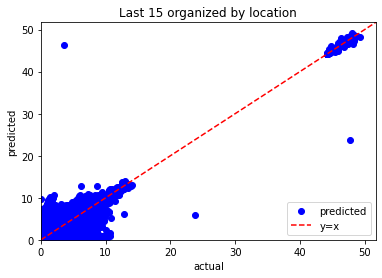

In [118]:
plot_results(X15, y15, "Last 15 organized by location")

### Previous day at same hour

### Previous week same day and same hour

# Average of individual houses

In [12]:
mse_15, rmse_15, mae_15, mape_15, r2_15 = total_averaged_metrics(metrics_15_list)

Total Averaged MSE: 0.223
Total Averaged RMSE: 0.426
Total Averaged MAE: 0.219
Total Averaged MAPE: 30.3
Total Averaged R2: 0.593


In [13]:
mse_prev_day, rmse_prev_day, mae_prev_day, mape_prev_day, r2_prev_day = total_averaged_metrics(metrics_day_list)

Total Averaged MSE: 0.86
Total Averaged RMSE: 0.764
Total Averaged MAE: 0.458
Total Averaged MAPE: 62.1
Total Averaged R2: -0.124


In [14]:
mse_prev_week, rmse_prev_week, mae_prev_week, mape_prev_week, r2_prev_week = total_averaged_metrics(metrics_week_list)

Total Averaged MSE: 1.179
Total Averaged RMSE: 0.83
Total Averaged MAE: 0.49
Total Averaged MAPE: 66.2
Total Averaged R2: -0.252


# Sum of all houses preprocessing
### Previous 15 minutes prediction data

In [96]:
X_total_15 = df_total.copy()
m = len(X_total_15)
X_total_15 = X_total_15.iloc[0:(m-1)]
X_total_15

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35130,62.642645
35131,49.211311
35132,43.139892
35133,44.599341


In [97]:
y_total_15 = df_total.copy()
y_total_15 = y_total_15.iloc[1:].reset_index(drop=True)
y_total_15

,Energy
0,57.575249
1,63.011688
2,62.735722
3,63.404029
4,63.710440
...,...
35130,49.211311
35131,43.139892
35132,44.599341
35133,28.956084


In [129]:
X_total_15_norm, scaler = normalize_training(X_total_15)
y_total_15_norm = scaler.transform(y_total_15)

### Previous day at same hour prediction data

In [130]:
X_total_prev_day = df_total.copy()
m = len(X_total_prev_day)
X_total_prev_day = X_total_prev_day.iloc[0:(m-96)]
X_total_prev_day

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35035,59.032763
35036,61.748938
35037,68.822483
35038,52.902303


In [131]:
y_total_prev_day = df_total.copy()
y_total_prev_day = y_total_prev_day.iloc[96:].reset_index(drop=True)
y_total_prev_day

,Energy
0,75.988362
1,73.248235
2,29.228225
3,26.668414
4,22.221842
...,...
35035,49.211311
35036,43.139892
35037,44.599341
35038,28.956084


In [132]:
X_total_prev_day_norm, scaler = normalize_training(X_total_prev_day)
y_total_prev_day_norm = scaler.transform(y_total_prev_day)

### Previous week same day at same hour prediction data

In [133]:
X_total_prev_week = df_total.copy()
m = len(X_total_prev_week)
X_total_prev_week = X_total_prev_week.iloc[0:(m-96*7)]
X_total_prev_week

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
34459,101.276378
34460,97.925796
34461,106.449744
34462,109.448934


In [134]:
y_total_prev_week = df_total.copy()
y_total_prev_week = y_total_prev_week.iloc[(96*7):].reset_index(drop=True)
y_total_prev_week

,Energy
0,38.397391
1,38.792453
2,30.128606
3,30.302314
4,33.274138
...,...
34459,49.211311
34460,43.139892
34461,44.599341
34462,28.956084


In [135]:
X_total_prev_week_norm, scaler = normalize_training(X_total_prev_week)
y_total_prev_week_norm = scaler.transform(y_total_prev_week)

## Prediction (sum of all houses)

#### R2 will be negative whenever your model's predictions are worse than a constant function that always predicts the mean of the data.

### Previous 15 minutes prediction data

In [136]:
mse_total_15, wape_total_15, r2_total_15 = no_ml_predict(X_total_15, y_total_15)

MSE: 129.6594
WAPE: 20.0000
R2: 0.6881


In [137]:
mse_total_15, wape_total_15, r2_total_15 = no_ml_predict(X_total_15_norm, y_total_15_norm)

MSE: 0.0052
WAPE: 23.0000
R2: 0.6881


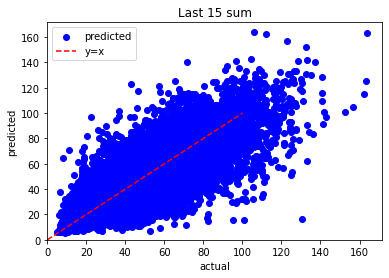

In [109]:
plot_results(X_total_15, y_total_15, "Last 15 sum")

### Previous day at same hour prediction data

In [110]:
mse_total_prev_day, wape_total_prev_day, r2_total_prev_day = no_ml_predict(X_total_prev_day, y_total_prev_day)

MSE: 399.0900
WAPE: 38.0000
R2: 0.0386


In [138]:
mse_total_prev_day, wape_total_prev_day, r2_total_prev_day = no_ml_predict(X_total_prev_day_norm, y_total_prev_day_norm)

MSE: 0.0159
WAPE: 44.0000
R2: 0.0386


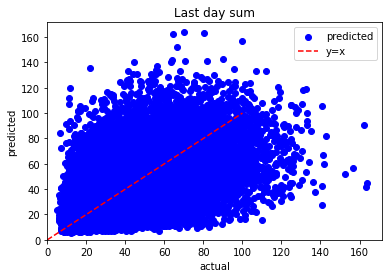

In [111]:
plot_results(X_total_prev_day, y_total_prev_day, "Last day sum")

### Previous week same day at same hour prediction data

In [140]:
mse_total_prev_week, wape_total_prev_week, r2_total_prev_week = no_ml_predict(X_total_prev_week, y_total_prev_week)

MSE: 463.2343
WAPE: 41.0000
R2: -0.1407


In [141]:
mse_total_prev_week, wape_total_prev_week, r2_total_prev_week = no_ml_predict(X_total_prev_week_norm, y_total_prev_week_norm)

MSE: 0.0184
WAPE: 47.0000
R2: -0.1407


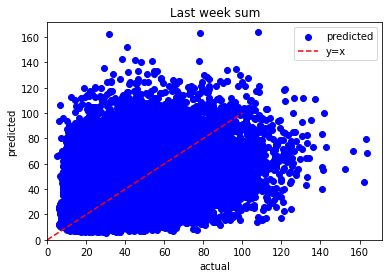

In [142]:
plot_results(X_total_prev_week, y_total_prev_week, "Last week sum")

## Comparison between individual and sum

C:\Users\fran_\anaconda3\lib\site-packages\numpy\lib\stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\fran_\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


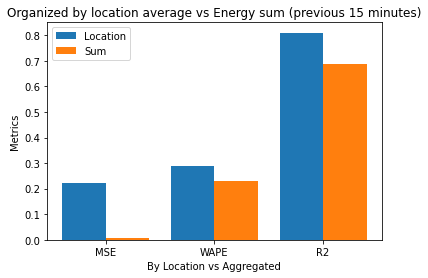

In [144]:
X_names = ("MSE", "WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (mse_15, wape_15, r2_15), 0.4, label = 'Location')
plt.bar(X_axis + 0.2, (mse_total_15, wape_total_15, r2_total_15), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("By Location vs Aggregated")
plt.ylabel("Metrics")
plt.title("Organized by location average vs Energy sum (previous 15 minutes)")
plt.legend()
plt.show()

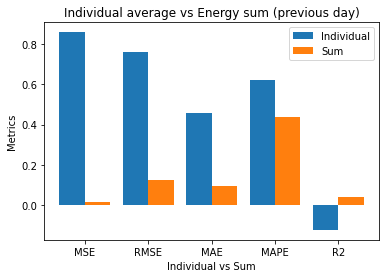

In [37]:
plt.bar(X_axis - 0.2, (mse_prev_day, rmse_prev_day, mae_prev_day, mape_prev_day, r2_prev_day), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (mse_total_prev_day, rmse_total_prev_day, mae_total_prev_day, mape_total_prev_day, r2_total_prev_day), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.title("Individual average vs Energy sum (previous day)")
plt.legend()
plt.show()

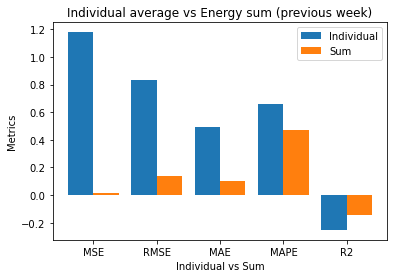

In [38]:
plt.bar(X_axis - 0.2, (mse_prev_week, rmse_prev_week, mae_prev_week, mape_prev_week, r2_prev_week), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (mse_total_prev_week, rmse_total_prev_week, mae_total_prev_week, mape_total_prev_week, r2_total_prev_week), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.title("Individual average vs Energy sum (previous week)")
plt.legend()
plt.show()